/home/mingjia/miniconda3/envs/llm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


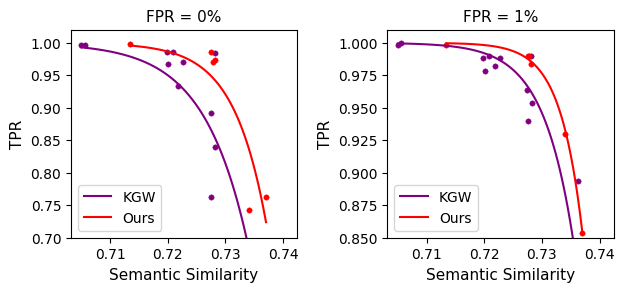

In [1]:
import matplotlib.pyplot as plt
import json
import math
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit

def fivepl(x, a, b, c, d, g):
    return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
def expfunc(x, a, b, c):
    return -a*np.exp(b*x)+1

# Multinomial

d_0 = {'0.25': []}
d_1 = {'0.25': []}
s = {'0.25': []}
p = {'0.25': []}

fig, ax = plt.subplots(1,2, figsize=(7, 2.7))
 
setting = 'setting_2'
gamma_list = ['0.25']
delta_list = {}

## PUT the delta here for each gamma
delta_list['0.25'] = ['0.8', '1.0','1.1','1.2','1.3','1.4','1.5','1.6','1.7','1.8','1.9','2.0','2.3','2.5']

for gamma in gamma_list:
    cur_delta_list = delta_list[gamma] 
    for delta in cur_delta_list:
        entry = json.load(open(f"cp_att_1/bs/{gamma}_{delta}.json"))
        entry_no_att = json.load(open(f"../eval/opt/bs_test/half/{gamma}_{delta}.json"))
        thres_0 = entry[setting]['wm_bs']['z']['thres_0'] / 500
        thres_1 = entry[setting]['wm_bs']['z']['thres_1'] / 500
        simcse = entry_no_att[setting]['wm_bs']['simcse']
        ppl = math.log(entry_no_att[setting]['wm_bs']['ppl'])

        d_0[gamma].append(thres_0)
        d_1[gamma].append(thres_1)
        s[gamma].append(simcse)
        p[gamma].append(ppl)

colors = ['purple', 'lightsteelblue', 'lavender','lightpink', 'darkorange','red']
x_label_list = ['SimCSE (better →)', 'PPL (better →)']

th_list = [0,1]
x_list = [s, s]
y_list = [d_0, d_1]
ppl_list = [ppl,ppl]


for ax_id in range(2):
    for i in range(len(gamma_list)):
        gamma = gamma_list[i]
        ax[ax_id].scatter(x_list[ax_id][gamma], y_list[ax_id][gamma], color=colors[i], s=15, linewidths=0.3)
        if ax_id == 1:
            popt, pcov = curve_fit(expfunc, x_list[ax_id][gamma], y_list[ax_id][gamma], maxfev=40000)
        else:
            popt, pcov = curve_fit(expfunc, x_list[ax_id][gamma], y_list[ax_id][gamma], maxfev=40000)
        x_fit = np.linspace(min(x_list[ax_id][gamma]), max(x_list[ax_id][gamma]), 100) 
        y_fit = expfunc(x_fit, *popt) 
        if 'entr' in gamma:
            ax[ax_id].plot(x_fit, y_fit, color=colors[i], label="SWEET") 
        else:
            ax[ax_id].plot(x_fit, y_fit, color=colors[i], label="KGW")
        
    ax[ax_id].legend(loc="lower left")
    ax[ax_id].set_ylabel('TPR', fontsize=11)
    ax[ax_id].set_xlabel('Semantic Similarity', fontsize=11)
    ax[ax_id].set_title(f"FPR = {str(th_list[ax_id])}%", fontsize=11)

            
ckpt_list = [
        "result/mlp_1_0.1/checkpoint_len_200_600.pth",
        "result/mlp_1_0.25/checkpoint_batch4_len_200_800.pth",
        "result/mlp_1.25/checkpoint_len_200_900.pth",
        "result/mlp_1.5/checkpoint_len_200_900.pth",
        "result/mlp_1.75/checkpoint_len_200_800.pth",
        "result/mlp_2/checkpoint_len_200_1200.pth",
    ]
gamma_list = ['0.1', '0.25', '0.25', '0.25', '0.25', '0.25']
delta_list = ['1.0','1.0','1.25','1.5','1.75','2.0'] # 1.25 1.75
ckpt_list_no_att = ['ckpt_600','ckpt_800','ckpt_900','ckpt_900','ckpt_800', 'ckpt_1200']

wm_file = json.load(open(f"cp_att_1/wm/wm_test.json"))

d = [[], []]
s, p = [], []
th_list = [0,1]

for idx in range(len(ckpt_list)):
    ckpt, gamma, delta = ckpt_list[idx], gamma_list[idx], delta_list[idx]
    wm = wm_file[ckpt][setting]['wm']
    wm_no_att = json.load(open(f"../eval/opt/wm_test/wm_test_{gamma}_{delta}_half.json"))[ckpt_list_no_att[idx]][setting]['wm']
    simcse = wm_no_att['simcse'] 
    ppl = math.log(wm_no_att['ppl']) 
    for j in range(len(th_list)):
        d[j].append(wm['z']['thres_'+str(th_list[j])] / 500)
    s.append(simcse)
    p.append(ppl)

x_list = [s, s]
y_list = d
for ax_id in range(2):
    ax[ax_id].scatter(x_list[ax_id], y_list[ax_id], color=colors[-1], s=15, linewidths=0.3)
    ax[ax_id].legend(loc="lower left")
    if ax_id == 0:
        popt, pcov = curve_fit(expfunc, x_list[ax_id], y_list[ax_id], maxfev=20000)
    else:
        popt, pcov = curve_fit(expfunc, x_list[ax_id], y_list[ax_id], maxfev=20000)
    x_fit = np.linspace(min(x_list[ax_id]), max(x_list[ax_id]), 100) 
    y_fit = expfunc(x_fit, *popt) 
    ax[ax_id].plot(x_fit, y_fit, color=colors[-1], label="Ours")
    ax[ax_id].legend(loc="lower left")
    
ax[0].set_ylim([0.7, 1.02])
ax[1].set_ylim([0.85, 1.01])
plt.subplots_adjust(wspace=0.4)  
plt.subplots_adjust(hspace=0.4) 
# plt.savefig("cp_1.pdf", bbox_inches='tight')

/home/mingjia/miniconda3/envs/llm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


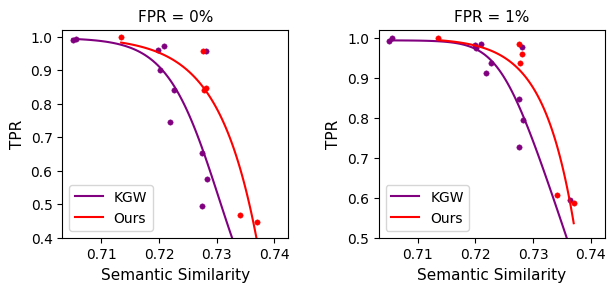

In [3]:
import matplotlib.pyplot as plt
import json
import math
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit

def fivepl(x, a, b, c, d, g):
    return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
def expfunc(x, a, b, c):
    return -a*np.exp(b*x)+1

# Multinomial

d_0 = {'0.25': []}
d_1 = {'0.25': []}
s = {'0.25': []}
p = {'0.25': []}

fig, ax = plt.subplots(1,2, figsize=(7, 2.7))
 
setting = 'setting_2'
gamma_list = ['0.25']
delta_list = {}

## PUT the delta here for each gamma
delta_list['0.25'] = ['0.8', '1.0','1.1','1.2','1.3','1.4','1.5','1.6','1.7','1.8','1.9','2.0','2.3','2.5']

for gamma in gamma_list:
    cur_delta_list = delta_list[gamma] 
    for delta in cur_delta_list:
        entry = json.load(open(f"cp_att_3/bs/{gamma}_{delta}.json"))
        entry_no_att = json.load(open(f"../eval/opt/bs_test/half/{gamma}_{delta}.json"))
        thres_0 = entry[setting]['wm_bs']['z']['thres_0'] / 500
        thres_1 = entry[setting]['wm_bs']['z']['thres_1'] / 500
        simcse = entry_no_att[setting]['wm_bs']['simcse']
        ppl = math.log(entry_no_att[setting]['wm_bs']['ppl'])

        d_0[gamma].append(thres_0)
        d_1[gamma].append(thres_1)
        s[gamma].append(simcse)
        p[gamma].append(ppl)

colors = ['purple', 'lightsteelblue', 'lavender','lightpink', 'darkorange','red']
x_label_list = ['SimCSE (better →)', 'PPL (better →)']

th_list = [0,1]
x_list = [s, s]
y_list = [d_0, d_1]
ppl_list = [ppl,ppl]


for ax_id in range(2):
    for i in range(len(gamma_list)):
        gamma = gamma_list[i]
        ax[ax_id].scatter(x_list[ax_id][gamma], y_list[ax_id][gamma], color=colors[i], s=15, linewidths=0.3)
        if ax_id == 1:
            popt, pcov = curve_fit(fivepl, x_list[ax_id][gamma], y_list[ax_id][gamma], maxfev=40000)
        else:
            popt, pcov = curve_fit(fivepl, x_list[ax_id][gamma], y_list[ax_id][gamma], maxfev=40000)
        x_fit = np.linspace(min(x_list[ax_id][gamma]), max(x_list[ax_id][gamma]), 100) 
        y_fit = fivepl(x_fit, *popt) 
        if 'entr' in gamma:
            ax[ax_id].plot(x_fit, y_fit, color=colors[i], label="SWEET") 
        else:
            ax[ax_id].plot(x_fit, y_fit, color=colors[i], label="KGW")
        
    ax[ax_id].legend(loc="lower left")
    ax[ax_id].set_ylabel('TPR', fontsize=11)
    ax[ax_id].set_xlabel('Semantic Similarity', fontsize=11)
    ax[ax_id].set_title(f"FPR = {str(th_list[ax_id])}%", fontsize=11)

            
ckpt_list = [
        "result/mlp_1_0.1/checkpoint_len_200_600.pth",
        "result/mlp_1_0.25/checkpoint_batch4_len_200_800.pth",
        "result/mlp_1.25/checkpoint_len_200_900.pth",
        "result/mlp_1.5/checkpoint_len_200_900.pth",
        "result/mlp_1.75/checkpoint_len_200_800.pth",
        "result/mlp_2/checkpoint_len_200_1200.pth",
    ]
gamma_list = ['0.1', '0.25', '0.25', '0.25', '0.25', '0.25']
delta_list = ['1.0','1.0','1.25','1.5','1.75','2.0'] # 1.25 1.75
ckpt_list_no_att = ['ckpt_600','ckpt_800','ckpt_900','ckpt_900','ckpt_800', 'ckpt_1200']

wm_file = json.load(open(f"cp_att_3/wm/wm_test.json"))

d = [[], []]
s, p = [], []
th_list = [0,1]

for idx in range(len(ckpt_list)):
    ckpt, gamma, delta = ckpt_list[idx], gamma_list[idx], delta_list[idx]
    wm = wm_file[ckpt][setting]['wm']
    wm_no_att = json.load(open(f"../eval/opt/wm_test/wm_test_{gamma}_{delta}_half.json"))[ckpt_list_no_att[idx]][setting]['wm']
    simcse = wm_no_att['simcse'] 
    ppl = math.log(wm_no_att['ppl']) 
    for j in range(len(th_list)):
        d[j].append(wm['z']['thres_'+str(th_list[j])] / 500)
    s.append(simcse)
    p.append(ppl)

x_list = [s, s]
y_list = d
for ax_id in range(2):
    ax[ax_id].scatter(x_list[ax_id], y_list[ax_id], color=colors[-1], s=15, linewidths=0.3)
    ax[ax_id].legend(loc="lower left")
    if ax_id == 0:
        popt, pcov = curve_fit(expfunc, x_list[ax_id], y_list[ax_id], maxfev=20000)
    else:
        popt, pcov = curve_fit(expfunc, x_list[ax_id], y_list[ax_id], maxfev=20000)
    x_fit = np.linspace(min(x_list[ax_id]), max(x_list[ax_id]), 100) 
    y_fit = expfunc(x_fit, *popt) 
    ax[ax_id].plot(x_fit, y_fit, color=colors[-1], label="Ours")
    ax[ax_id].legend(loc="lower left")
    
ax[0].set_ylim([0.4, 1.02])
ax[1].set_ylim([0.5, 1.02])
plt.subplots_adjust(wspace=0.4)  
plt.subplots_adjust(hspace=0.4) 
# plt.savefig("cp_3.pdf", bbox_inches='tight')